# **Objective - To Detect abnormal beats in ECG waveforms.**

Suppose that we want to detect abnormal beats in an ecg waveform. We first gather information about the normal rhythm of the patient and encode the normal beats using an LSTM Auto-Encoder and then use simple thresholding on reconstruction error for classification. An advantage of this approach is that labeled data from only the Normal class is required for training.



__________________________________________________________________
> *For mini-project CS575 (Applied Time Series Analysis), May 2021*

In [1]:
%reset

# Global Section

In [2]:
import datetime
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Dense, RepeatVector, TimeDistributed, Flatten, LSTM
from tensorflow.keras import Model

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

########################################################################
# global variables
########################################################################
# Resampled every signal to this rate for consistency
BASIC_SRATE = 128 #Hz
print('Basic sampling rate(Hz):',BASIC_SRATE)

# >------ parent db directory ------------------------------------------
DB_NPY = 'db_npy'
print('DATASET DIR ::',DB_NPY)

# >------ load standard labels ------------------------------------------
std_annotations = os.path.join(DB_NPY,'annotations.txt')
print('STD ANN FILE ::',std_annotations)
std_ant = np.loadtxt(std_annotations, dtype='str',delimiter="\t")

#------------------------------------------------------------------------
# Seperate out stand beat and non-beat annotations using 'annotations.txt'
beat_ants = []
non_beat_ants = []
print('\nStandard Labels::')
for a in std_ant:
    # a[0] =  # standard label (char)
    # a[1] =  # type of label
    # a[2]  = # description (str)
    print(a[0]+'\t'+a[1]+'\t'+a[2])
    if a[1]=='b': #<<--- is a beat-annotation
        beat_ants.append(a[0])
    else:
        non_beat_ants.append(a[0])

print('')
print('beat-annotation:',len(beat_ants))
print('non-beat-annotation:',len(non_beat_ants))
#-----------------------------------------------------------------------------
gbreak = '____________________________________________________________________'
#-----------------------------------------------------------------------------
# data file identifiers 
g_BEAT = '_BEAT.npy'       #<<--- beat annotations
g_NBEAT = '_NBEAT.npy'     #<<--- non-beat annotations
g_SIG2 = '_SIG_II.npy'     #<<--- Signal Data (Removed manual gain)

Basic sampling rate(Hz): 128
DATASET DIR :: db_npy
STD ANN FILE :: db_npy\annotations.txt

Standard Labels::
N	b	Normal beat
L	b	Left bundle branch block beat
R	b	Right bundle branch block beat
B	b	Bundle branch block beat (unspecified)
A	b	Atrial premature beat
a	b	Aberrated atrial premature beat
J	b	Nodal (junctional) premature beat
S	b	Supraventricular premature or ectopic beat (atrial or nodal)
V	b	Premature ventricular contraction
r	b	R-on-T premature ventricular contraction
F	b	Fusion of ventricular and normal beat
e	b	Atrial escape beat
j	b	Nodal (junctional) escape beat
n	b	Supraventricular escape beat (atrial or nodal)
E	b	Ventricular escape beat
/	b	Paced beat
f	b	Fusion of paced and normal beat
Q	b	Unclassifiable 
?	b	Beat not classified during learning
[	n	Start of ventricular flutter/fibrillation
!	n	Ventricular flutter wave
]	n	End of ventricular flutter/fibrillation
x	n	Non-conducted P-wave (blocked APC)
(	n	Waveform onset
)	n	Waveform end
p	n	Peak of P-wave
t	n	Peak of 

# Custom Labels

In [3]:
#<< --- define custom labels. 
_N = '_N'  # N - normal class - Non-Ectopic
_S = '_S'  # S - SupraVentricular Ectopic Beats (SVEBs)
_V = '_V'  # V - Ventricular Ectopic Beats (VEBs)
_F = '_F'  # F - Fusion Beats
_Q = '_Q'  # Q - Unrecognized
_X = '_X'  # X - Unmapped - if you don't want to use a lable, map it under this class - it should not be used in classification

custom_ants = [ _N, _S, _V, _F, _Q ]  # as recomended by AAMI

# define a mapping dictionary #----------------------------------
custom_cols = { _N:'tab:green',
                _S:'tab:red',
                _V:'tab:blue',
                _F:'tab:purple',
                _Q:'yellow',
                _X:'tab:gray'}
custom_mapping = {
                    #<--- Normal Class
                    'N': _N, 
                    'L': _N,
                    'R': _N,
                    'B': _N,
    
                    #<--- SVEB
                    'A': _S,
                    'a': _S,
                    'J': _S,
                    'S': _S,
    
                    #<--- VEB
                    'V': _V, 
                    'r': _V,
    
                    #<--- FUSION
                    'F': _F,
    
                    #<---* Supraventricular escape - aami says its normal but should be mapped to _S
                    'e': _S,
                    'j': _S,
                    'n': _S,
    
                    #<---* Ventricular escape - aami says its normal but should be mapped to _V
                    'E': _V,
    
                    #<--- Paced beats are unmapped - dont use record containing paced beats (mitdb - 102,104,107,217)
                    'f': _X,
                    '/': _X,
    
                    #<--- Unrecognised or Unclassifiable
                    'Q': _Q,
                    '?': _Q,
                }

# Use objects to represent ecg databases and records

In [4]:
##############################################################################################################################3
# CLASS DEFS
##############################################################################################################################3

#<-------------------------------------------------------------------------------------------------- Represent one ECG database
class ecgDatabase:
    def __init__(self, db_name, db_path):
        self.db_name = db_name
        self.db_path = db_path
        self._prepare()
        
    def _prepare(self):
        # 1. read record list
        self.record_list = np.loadtxt(os.path.join(self.db_path,'RECORDS'), dtype='str',delimiter="\n")
        if len(self.record_list.shape)==0:
            self.record_list = np.array([self.record_list])
        
        # 2. prepare a dictionary of ecgRecord objects
        self.records = {}
        for irec in self.record_list:
            self.records[irec] = ecgRecord(irec,os.path.join(self.db_path),self.db_name) 
            #<--- records are not loaded initially, will be loaded dynamically
        return
        
    def get_record(self, rec_name):
        if rec_name in self.records.keys():
            this_rec = self.records[rec_name]
            if not this_rec.isloaded:
                this_rec.loadfromdisk()  #<--- Loads records dynamically, on call to this function
            return this_rec
        else:
            return None  #<--- No record with name <rec_name>

#<------------------------------------------------------------------------------------------------- Represent one ECG Record        
class ecgRecord:
    def __init__(self, arg_recname, arg_path, db_name):
        self.dbname = db_name
        self.path = arg_path
        self.name = arg_recname
        self.isloaded = False
        
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REQUIRED
    def loadfromdisk(self, verbose=0):
        if verbose>0:
            print('\nLoading Record:', self.name)
        #<<---------------------------------------------
        # Load Signal Data
        #<<---------------------------------------------
        self.signal_file = os.path.join(self.path,self.name + g_SIG2)
        self.iSignal = np.load(self.signal_file)
        if verbose>0:
            print('Signal Length:',self.iSignal.shape)
            print('Signal Duration:',len(self.iSignal)/BASIC_SRATE, 'sec')
        
        #<<---------------------------------------------
        # Load Beat-Annotation (Labels)
        #<<---------------------------------------------
        self.beat_file = os.path.join(self.path,self.name + g_BEAT)
        self.iBeat = np.load(self.beat_file)
        if verbose>0:
            print('#Beats:',self.iBeat.shape)
        # seperate out R-peaks and Labels (note both are in string format)
        self.iRpeaks = self.iBeat[:,0].astype('int') #<<-- convert sampling locations to integer
        self.iLabels = self.iBeat[:,1]               #<<-- labels remain as string
        self.nos_beats = len(self.iRpeaks)
        
        #<<---------------------------------------------thats it, Non-Beat-Annotation not required
        self.isloaded = True
        return self.isloaded
    
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REQUIRED
    # for mapping custom labels   ** rec.mLabels = rec.map_beat_labels(custom_mapping)
    # must be called after loading record to be able to use custom mapping
    def map_beat_labels(self, c_mapping, c_colors):
        self.mLabels = np.zeros(len(self.iLabels), dtype='U2')
        self.mColors = np.zeros(len(self.iLabels), dtype='U10')
        for i in range(0,len(self.iLabels)):
            self.mLabels[i]=c_mapping[self.iLabels[i]]
            self.mColors[i]=c_colors[self.mLabels[i]]
            
        return len(self.mLabels)
    
#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Fixed Duration Signal 
    # Gets Signal Data of fixed duration along with indices of r-peaks in the range
    # pf and pt are measured in samples not seconds 
    # to convert use, samples =  int(seconds / BASIC_SRATE)   ** must be integers
    # can be negative too
    
    def get_true_range(self,pf,pt):

        N = len(self.iSignal)
        if pt<pf:
            pt,pf = pf,pt # swap
            
        if pf<0:
            pf=0
        elif pf>=N:
            pf=N-1
            
        if pt<0:
            pt=0
        elif pt>N:
            pt=N
        return pf, pt
            
    def get_signal_slice_fd(self,pf, pt):
        signal_slice = self.iSignal[pf:pt]
        signal_list = np.where((self.iRpeaks>=pf) & (self.iRpeaks<pt))[0]
        return signal_slice, signal_list, pf, pt

#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Variable Length Representation
    # Gets Signal data of beat at 'beat_index'. (Variable Length)
    # On the left, take signal data upto R-peak of beat 'minus_i' indices before it and trim by 'signal_trim_left'
    # On the right, take signal data upto R-peak of beat 'plus_i' indices after it and trim by 'signal_trim_right'
    # trim params can be negative too
    def get_signal_slice_biV(self, beat_index, minus_i, plus_i ,signal_trim_left, signal_trim_right ):
        RpeakL = self.iRpeaks[beat_index-minus_i]+signal_trim_left
        RpeakC = self.iRpeaks[beat_index]
        RpeakR = self.iRpeaks[beat_index+plus_i]-signal_trim_right
        pf,pt = RpeakL,RpeakR
        signal_slice=self.iSignal[pf:pt]
        signal_list = np.where((self.iRpeaks>=pf) & (self.iRpeaks<pt))[0]
        return signal_slice, signal_list, pf, pt

    # a shorter version of above function. use when only the signal data is required
    def get_signal_slice_biV_(self, beat_index, minus_i, plus_i ,signal_trim_left, signal_trim_right ):
        return self.iSignal[self.iRpeaks[beat_index-minus_i]+signal_trim_left:self.iRpeaks[beat_index+plus_i]-signal_trim_right]

#<~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Fixed Length Representation
    # Gets Signal data of beat at 'beat_index'. (Fixed Length)
    def get_signal_slice_biF(self, beat_index, left_samples, right_samples ):
        Rpeak = self.iRpeaks[beat_index]
        pf, pt =  Rpeak-left_samples, Rpeak+right_samples
        signal_slice = self.iSignal[pf:pt]
        signal_list = np.where((self.iRpeaks>=pf) & (self.iRpeaks<pt))[0]
        return signal_slice, signal_list, pf, pt
    
    # a shorter version of above function. use when only the signal data is required
    def get_signal_slice_biF_(self, beat_index, left_samples, right_samples ):
        return self.iSignal[self.iRpeaks[beat_index]-left_samples:self.iRpeaks[beat_index]+right_samples]
#-------------------------------------------------------------------------------------------------------------------
# NOTE: be careful with out of range indices - use rec.get_true_range(pf,pt)
#-------------------------------------------------------------------------------------------------------------------

# functions for plotting
yll, yul, ycl = -3, 3.5, -2.8

def plot_beat(signal_slice, signal_list, pf, pt, ph,
                show_label_ticks=False, show_custom_labels=True, show_custom_vline=False,
                w=0.012, h=4, r=0.5):
    
    plt.figure(figsize=(w*len(signal_slice),h), constrained_layout=True)
    plt.ylim(yll, yul)
    plt.xlim(pf,pt)
    
    ilen = len(signal_list)
    _range = np.arange(pf,pt,BASIC_SRATE)
    _peaks = rec.iRpeaks[signal_list]
    _labels = rec.iLabels[signal_list]
    _colorL = rec.mColors[signal_list]
    
    # plot the signal
    plt.plot(np.arange(pf,pt,1), signal_slice, color='black',linewidth=0.8)
    plt.vlines(ph,yll,yul,linewidth=0.8,color='black' )
    
    # plot ticks
    if show_label_ticks:
        plt.xticks(_peaks,_labels) #-pf*BASIC_SRATE
        plt.grid( axis='x')
    else:
        plt.xticks(_range,np.round(_range/BASIC_SRATE,2))#,rotation=60)

    # plot labels
    if show_custom_labels:
        plt.scatter(_peaks ,np.zeros(ilen)+ycl, c=_colorL)
        if show_custom_vline:
            for j in range(0,ilen):
                plt.annotate(signal_list[j],xy=(_peaks[j],ycl+0.3) )
                plt.vlines(_peaks[j],yll,yul,linewidth=0.4,color=_colorL[j])

    
    plt.show()
    return
#

#===============================================================
# PERFORMANCE =================================================
#===============================================================
#------------------------------------------------------------------
# Confusion Matrix
#------------------------------------------------------------------
def _print_header(class_labels):
    g_HSTR=''   # HEADER ROW for printing confusing matrix
    for i in range(0,len(class_labels)):
        g_HSTR+='\t'+str(class_labels[i])
    return  g_HSTR
def _print_rows(cm_row, nos_labels):
    g_RSTR = ''
    for j in range(0,nos_labels):
        g_RSTR += '\t'+ str(cm_row[j])
    return g_RSTR
def print_conf_matrix(conf_matrix, suffix, class_labels):
    g_CMSTR=(suffix+'T\\P' + _print_header(class_labels)+'\n')
    nos_l=len(class_labels)
    for i in range(0,nos_l):
        g_CMSTR+=(suffix+str(class_labels[i]) + _print_rows(conf_matrix[i],nos_l )+'\n')
    return g_CMSTR

#------------------------------------------------------------------
# Performance Measures
#------------------------------------------------------------------
def _get_performance(conf_matrix):
    nos_class = len(conf_matrix[0,:]) # len of 0th row
    perf_measures_array = np.zeros((0,11),dtype ='float64')
    for i in range(0,nos_class):
        
        CLASS_ACTUAL = np.sum(conf_matrix[i,:]) #<---- ROW SUM = NOS TRUE CLASS
        CLASS_PRED = np.sum(conf_matrix[:,i])      #<---- COL SUM = NOS PRED CLASS
        MSUM = np.sum(conf_matrix)  # = TP + FN + FP + TN
        
        # compute TP, TN, FP, FN ---------------------------- 
        TP = conf_matrix[i,i]
        FP =  CLASS_PRED - TP
        FN = CLASS_ACTUAL - TP
        TN =  MSUM- FN - FP - TP #<------------ this methods counts more than true negative
        #TN = np.sum(conf_matrix[np.diag_indices(nos_class)]) - TP..

        #Accuracy #<-= how many samples correctly classifed out of all samples
        ACC = (TP+TN)   /   ( MSUM)  
        
        #Precision = TP/CLASS_PRED    #<- = how many samples correctly predicted as true out of all samples predicted as true
        PRE = (TP)      /   (TP+FP)         #Presicion
        
        #Sensetivity = TP/CLASS_ACTUAL #<- = how many samples correctly predicted as true out of all actually true samples
        SEN = (TP)      /   (TP+FN)         #Sensitivity/Recall
        
        #Specificity #<-= how many samples correctly predicted false out of all samples predicted as false
        SPF = (TN)      /   (TN+FP)         
        
        # F1-Score #<-= 2*TP / (CLASS_ACTUAL + CLASS_PRED) 
        F1S = 2*PRE*SEN /   (PRE+SEN)       #F1 score #<-= harmonic mean of Precision and Sensetivity

        prefi = np.array([CLASS_ACTUAL , CLASS_PRED, TP, FN, FP, TN, ACC, PRE, SEN, SPF, F1S])
        perf_measures_array = np.vstack((perf_measures_array,prefi))
        
    return perf_measures_array, nos_class
def print_performance(conf_matrix, class_labels, do_round=-1):
    #header_string = 'Class\tACC\tPRE\tSEN\tSPF\tF1S'
    header_string = 'Class\t#True\t#Pred\tTPs\tFNs\tFPs\tTNs\tACC\tPRE\tSEN\tSPF\tF1S'
    perf_measures, nos_class = _get_performance(conf_matrix)
    if len(class_labels)!=nos_class:
        print('WARNING:: Class label count mismatch!! Cannot print performance')
        return -1
    #nos_class = len(perf_measures[:,0])
    print('Performance for '+str(nos_class)+' classes')
    print (header_string)
    for i in range(0, nos_class):
        if do_round<0:
          perf_i = perf_measures [i,:]
        else:
          perf_i = np.round(perf_measures [i,:],do_round)
          
        print(
              str(class_labels[i])+'\t'+
              str(perf_i[0])+'\t'+
              str(perf_i[1])+'\t'+
              str(perf_i[2])+'\t'+
              str(perf_i[3])+'\t'+
              str(perf_i[4])+'\t'+
              str(perf_i[5])+'\t'+
              str(perf_i[6])+'\t'+
              str(perf_i[7])+'\t'+
              str(perf_i[8])+'\t'+
              str(perf_i[9])+'\t'+
              str(perf_i[10])
              )
    return nos_class
	

# **Select a Database**

In [5]:
sel_db_name = 'mitdb' # [ select from - 'mitdb', 'svdb', 'incartdb']
sel_db_path = os.path.join(DB_NPY, sel_db_name+'_npy')
sel_db_files = os.listdir(sel_db_path)
print(sel_db_path,',', len(sel_db_files) , 'files')

dbo = ecgDatabase(sel_db_name, sel_db_path)
print(dbo.record_list.shape,dbo.record_list)


db_npy\mitdb_npy , 143 files
(48,) ['100' '101' '102' '103' '104' '105' '106' '107' '108' '109' '111' '112'
 '113' '114' '115' '116' '117' '118' '119' '121' '122' '123' '124' '200'
 '201' '202' '203' '205' '207' '208' '209' '210' '212' '213' '214' '215'
 '217' '219' '220' '221' '222' '223' '228' '230' '231' '232' '233' '234']


# Select a Record

In [6]:
recn = np.random.choice(dbo.record_list,size=1)[0]  #'116'
rec = dbo.get_record(recn)
print(rec.name, '\t'+str(rec.nos_beats)+ ' beats')
nos_map = rec.map_beat_labels(custom_mapping, custom_cols)# <<-- custom lables
print('Mapped Labels:', nos_map)

112 	2539 beats
Mapped Labels: 2539


# Investigate

In [7]:
timestamp_start = datetime.datetime.now()
# Find Count of all beats
print('Recod:',rec.dbname+'/'+rec.name, '\t'+str(rec.nos_beats)+ ' beats')
print(gbreak)
print('Standard Label Count')
saDict={}
sum = 0
for sa in  beat_ants:
    saDict[sa] = np.where(rec.iLabels==sa)[0]
    isum = len(saDict[sa])
    sum+=isum
    print(sa,'\t\t',isum)
print('__','\t\t',sum)
print(gbreak)
print('\nCustom Label Count')
caDict={}
sum = 0
for ca in  custom_ants:
    caDict[ca] = np.where(rec.mLabels==ca)[0]
    isum = len(caDict[ca])
    sum+=isum
    print(ca,'\t\t',isum)
print('__','\t\t',sum)
print(gbreak)
# RR-intervals  **NOTE:: SKIPPING FIRST AND LAST BEAT OF THE RECORD
rp_p, rp_c, rp_n = rec.iRpeaks[0:-2], rec.iRpeaks[1:-1], rec.iRpeaks[2:]
mLabels_p, mLabels_c, mLabels_n = rec.mLabels[0:-2],rec.mLabels[1:-1],rec.mLabels[2:]

rri_prev = (rp_c-rp_p)                 #<-- previous rr-interval
rri_next = (rp_n-rp_c)                 #<-- next rr-interval
rri_mean = (rri_prev + rri_next)/2       #<-- mean of prev and next
rri_delta = rri_next - rri_prev        #<-- delta b/w prev and next
rri_delta_abs = np.abs(rri_delta)       #...... for a normal rhythm, rri_abs_delta should be very small

ABS_DELTA_LIM = int(0.04*BASIC_SRATE)  #-- define a limit on rri_delta_abs for a beat to be considered Normal rhythm = 0.04 sec


# Any Normal: All Normal beats
NN_all = np.where((mLabels_c==_N))[0]+1

# True Normal: a Normal beat surronded by normal beats on both sides
NN_true = np.where((mLabels_p==_N) & (mLabels_c==_N) & (mLabels_n==_N))[0]+1

# Semi Normal: Normal beat surronded by atleast one abnormal beat on any side
NN_semi = np.where((mLabels_c==_N) & ((mLabels_p!=_N) | (mLabels_n!=_N)))[0]+1

# Absolute Normal: True Normal and delta_abs_rri < ABS_DELTA_DUR
NN_abs = np.where((mLabels_p==_N) & (mLabels_c==_N) & (mLabels_n==_N)
                  & (rri_delta_abs<=ABS_DELTA_LIM))[0] + 1

# Abnormal beats
AA_all =np.where((mLabels_c!=_N))[0] + 1 
SS_all =np.where((mLabels_c==_S))[0] + 1
VV_all =np.where((mLabels_c==_V))[0] + 1
FF_all =np.where((mLabels_c==_F))[0] + 1
QQ_all =np.where((mLabels_c==_Q))[0] + 1


# Unmapped beats
XX_all = np.where((mLabels_c==_X))[0] + 1


print("\nNormals\t\t", len(NN_all))
print(" True-type\t", len(NN_true))
print(" Semi-type\t", len(NN_semi))
print(" Abs-type\t", len(NN_abs))
print("\nAbnormals\t", len(AA_all))
print(" S-type\t\t", len(SS_all))
print(" V-type\t\t", len(VV_all))
print(" F-type\t\t", len(FF_all))
print(" Q-type\t\t", len(QQ_all))
print("\nUnmapped\t", len(XX_all))
print(gbreak)
print('\nElapsed time = ',datetime.datetime.now() - timestamp_start)

Recod: mitdb/112 	2539 beats
____________________________________________________________________
Standard Label Count
N 		 2537
L 		 0
R 		 0
B 		 0
A 		 2
a 		 0
J 		 0
S 		 0
V 		 0
r 		 0
F 		 0
e 		 0
j 		 0
n 		 0
E 		 0
/ 		 0
f 		 0
Q 		 0
? 		 0
__ 		 2539
____________________________________________________________________

Custom Label Count
_N 		 2537
_S 		 2
_V 		 0
_F 		 0
_Q 		 0
__ 		 2539
____________________________________________________________________

Normals		 2535
 True-type	 2531
 Semi-type	 4
 Abs-type	 2498

Abnormals	 2
 S-type		 2
 V-type		 0
 F-type		 0
 Q-type		 0

Unmapped	 0
____________________________________________________________________

Elapsed time =  0:00:00.008014


# LSTM Autoencoder Model and Parameters

In [8]:
lsamp, rsamp = int(0.4*BASIC_SRATE),int(0.4*BASIC_SRATE)+1
seqlen=lsamp+rsamp
print(lsamp,',',rsamp,',',seqlen)

51 , 52 , 103


# Select Training Beats

Preparing... 10


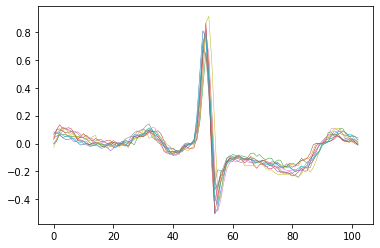

mitdb/112 Done.

Elapsed time =  0:00:00.121739


In [9]:
timestamp_start = datetime.datetime.now()
# select a bet to train upon
NNc = NN_abs #<--- learn the Absolute normals
train_on = min(10,len(NNc)) # train on less number of beats
for_train_N = np.random.choice(NNc, size=train_on, replace=False )
later_recr = np.random.choice(for_train_N, size=1, replace=False ) #<--- will use this beat for reconstruction

#---------------------------------------------Prepare for Training
sequence_length = seqlen
nncount = len(for_train_N)
data_listN=[]
print('Preparing...',nncount )    
 # reshape input into [samples, timesteps, features]
for i in range(0,nncount):
    b_index = for_train_N[i]
    signal_, _,_,_ = rec.get_signal_slice_biF(b_index,lsamp, rsamp)
    assert (sequence_length==len(signal_))
    data_listN.append(signal_)
    plt.plot(signal_, linewidth=0.5)
plt.show()
data_ = np.array(data_listN).reshape((len(data_listN), sequence_length, 1))
np.random.shuffle(data_)

print(rec.dbname+'/'+rec.name,'Done.')
print('\nElapsed time = ',datetime.datetime.now() - timestamp_start)

# Define Model Parameters and Reconstruction Error

In [10]:
def get_model_LAE(n_in, lstm_cells, Print_Summary=True, do_compile= True, initial_lr = 0.01):
    # define model - simple model with 1 layer
    
    lmodel = Sequential(name='LSTM_AutoEncoder') #samples, timesteps, features
    #<<-- add batch Norm???- 
    lmodel.add(Input(shape=(n_in,1)))
    lmodel.add(
                tf.keras.layers.BatchNormalization(axis=-2,
                                        momentum=0.99,
                                        epsilon=0.001,
                                        center=False,
                                        scale=True,
                                        trainable=False,
                                        virtual_batch_size=None,
                                        adjustment=None,
                                        name="BatchNorm")
                )
    lmodel.add(LSTM(lstm_cells,  name="LEncoder",activation='elu', input_shape=(n_in,1)))  #<<-- why elu?? - try different things here?
    lmodel.add(RepeatVector(n_in, name="Rep"))
    lmodel.add(LSTM(lstm_cells, name="LDecoder", activation='elu', return_sequences=True))
    lmodel.add(TimeDistributed(Dense(1, name="TimeDist")))

    if do_compile:
        lmodel.compile(optimizer=tf.optimizers.Adam(learning_rate=initial_lr),loss='mean_absolute_error',) #<--- any other optimizer?

    if Print_Summary:
        print(lmodel.summary())
    return lmodel

#========================================================================================
e_ylim = 2.0
def Rec_Error(delta_error): # #<--- Which one to choose as reconstruction error?
    return np.mean(delta_error) #<--- Mean Absolute Error
    #return np.sum(delta_error)  #<--- Summation of Absolute Error
    #return np.mean(delta_error**2) #<--- Mean Squared Error

# Callback Handlers

In [11]:
def _deltaLR( epoch, lr):
    global hist_LR
    
    #---------------------------------------------------
    new_lr = lr      # not controlled
    #---------------------------------------------------
    
    hist_LR[epoch]=new_lr
    return new_lr

def _epoch_end( _epoch, _logs):
    if _epoch%50 == 0:
        print('epoch:', _epoch)
    return


# Create Callbacks

In [12]:
#========================================================================================
# any callbacks here
cb_ES_loss = tf.keras.callbacks.EarlyStopping(
        monitor='loss', 
        min_delta=0.001, 
        patience=50, 
        verbose=1,
        mode='auto',
        baseline=None,
        restore_best_weights=True)
cb_BASE = tf.keras.callbacks.LambdaCallback(
        on_train_begin =  None, #lambda logs: _start_train() ,
        on_epoch_begin =  None, #lambda epoch,logs: _start_epoch(epoch) ,
        on_batch_begin =  None, #lambda batch,logs: _start_batch(batch),
        on_batch_end =    None, #lambda batch,logs: _record_batch(logs['accuracy'], logs['loss']) ,
        on_epoch_end =    lambda epoch,logs: _epoch_end(epoch, logs),
        on_train_end =    None #lambda logs: _print_results(logs['accuracy'], logs['loss'],logs['val_accuracy'], logs['val_loss'])
        )
cb_LRS = tf.keras.callbacks.LearningRateScheduler(_deltaLR, verbose=0)
cb_list = [cb_ES_loss,cb_LRS, cb_BASE] 

# Create LSTM Autoencoder Model

In [13]:
nos_cell = int(seqlen*0.75)
model = get_model_LAE(seqlen,nos_cell,initial_lr=0.001) #<-- start with high learn rate?

Model: "LSTM_AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BatchNorm (BatchNormalizati  (None, 103, 1)           309       
 on)                                                             
                                                                 
 LEncoder (LSTM)             (None, 77)                24332     
                                                                 
 Rep (RepeatVector)          (None, 103, 77)           0         
                                                                 
 LDecoder (LSTM)             (None, 103, 77)           47740     
                                                                 
 time_distributed (TimeDistr  (None, 103, 1)           78        
 ibuted)                                                         
                                                                 
Total params: 72,459
Trainable params: 72,150
Non-

# [] Train the model []

In [14]:
n_epchoc = 1000
b_size = int(nncount*0.25) # 25% batch size
hist_LR = np.zeros(n_epchoc)-1

timestamp_start = datetime.datetime.now()
history = model.fit(data_, data_, 
                    epochs=n_epchoc,
                    shuffle=True, 
                    batch_size=b_size, 
                    verbose=0, 
                    callbacks=cb_list)
print('Recent Loss:',history.history['loss'][-5:])
print('\nElapsed time = ',datetime.datetime.now() - timestamp_start)

epoch: 0
epoch: 50
epoch: 100
epoch: 150
epoch: 200
epoch: 250
epoch: 300
epoch: 350
epoch: 400
Restoring model weights from the end of the best epoch: 372.
Epoch 422: early stopping
Recent Loss: [0.02361251413822174, 0.026230573654174805, 0.0257584061473608, 0.020055804401636124, 0.019807618111371994]

Elapsed time =  0:01:00.580913


# View Training Result

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


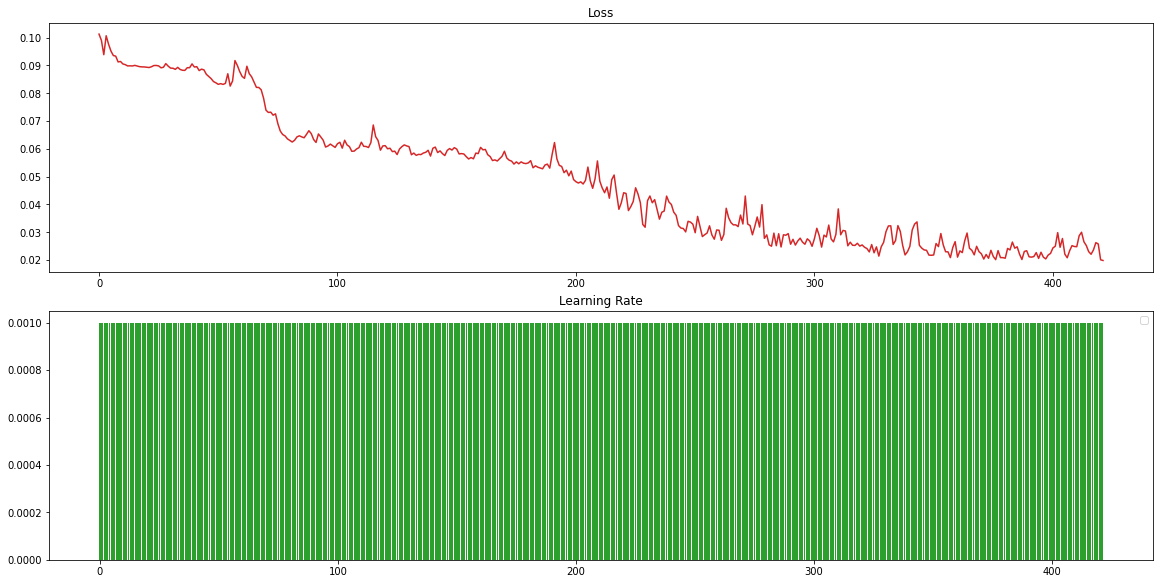

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(16,8),  constrained_layout=True)
ax[0].set_title('Loss')
ax[0].plot(history.history['loss'],color='tab:red', label='train_loss')

hist_LRd = hist_LR[np.where(hist_LR>=0)]
ax[1].set_title('Learning Rate')
ax[1].bar(np.arange(0,len(hist_LRd),1),hist_LRd,color='tab:green')

plt.legend()
plt.show()

# Reconstruction of a training beat

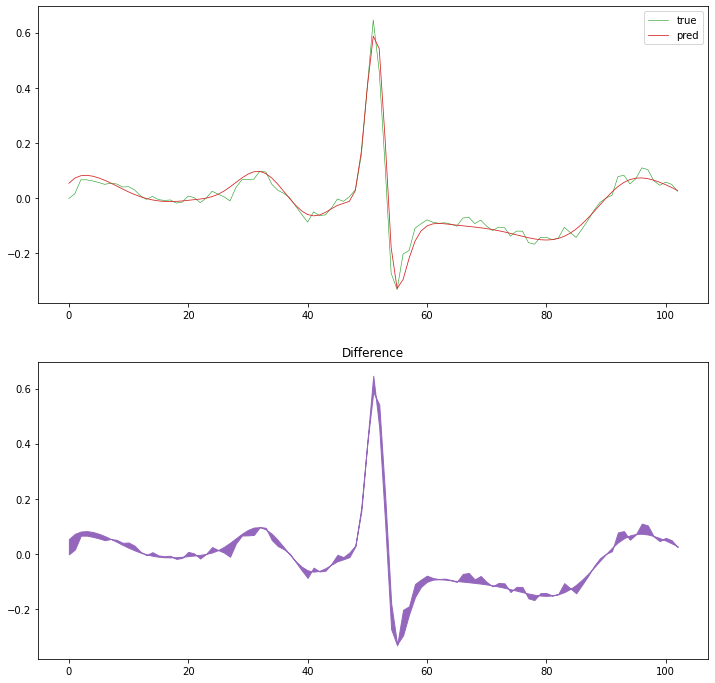

Error: 0.017432348925337782


In [16]:
# predict from training Example
signal_, _,_,_ = rec.get_signal_slice_biF(later_recr[0],lsamp, rsamp)
assert (seqlen == len(signal_))
sequence = signal_.reshape((1,seqlen, 1))
ypred = model.predict(sequence, verbose=0)
dE = np.abs(ypred[0,:,0] - sequence[0,:,0])

fig,ax = plt.subplots(2,1,figsize=(12,12))
ax[1].fill_between(np.arange(0,seqlen,1), ypred[0,:,0], sequence[0,:,0], color = 'tab:purple')
ax[1].set_title('Difference')
ax[0].plot(sequence[0,:,0], label='true', color='tab:green', linewidth=0.6)
ax[0].plot(ypred[0,:,0], label='pred', color='tab:red', linewidth=0.8)
ax[0].legend()
plt.show()
print('Error:', Rec_Error(dE))

# Reconstruction of a test beat

Normal# 1375  Label: _N N
Error: 0.0286955363882452


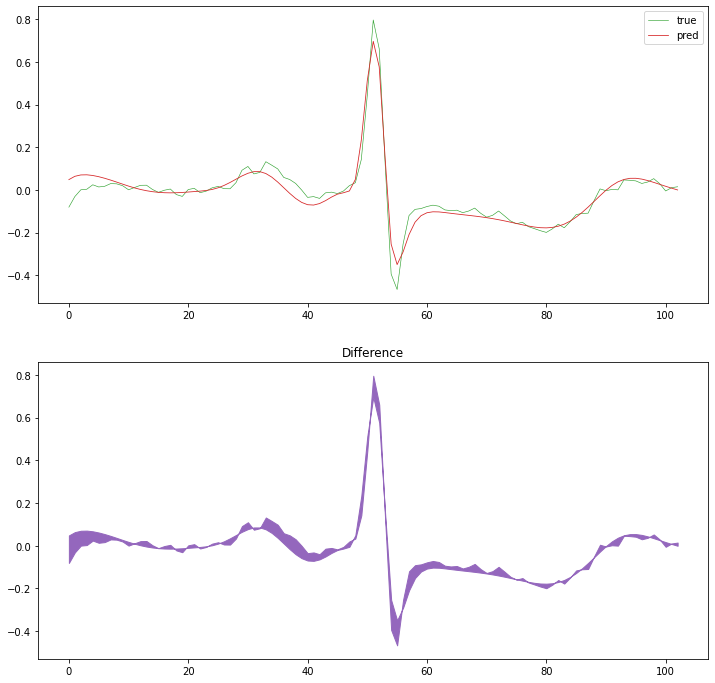

Abnormal# 1003  Label: _S A
Error: 0.06295834631958681


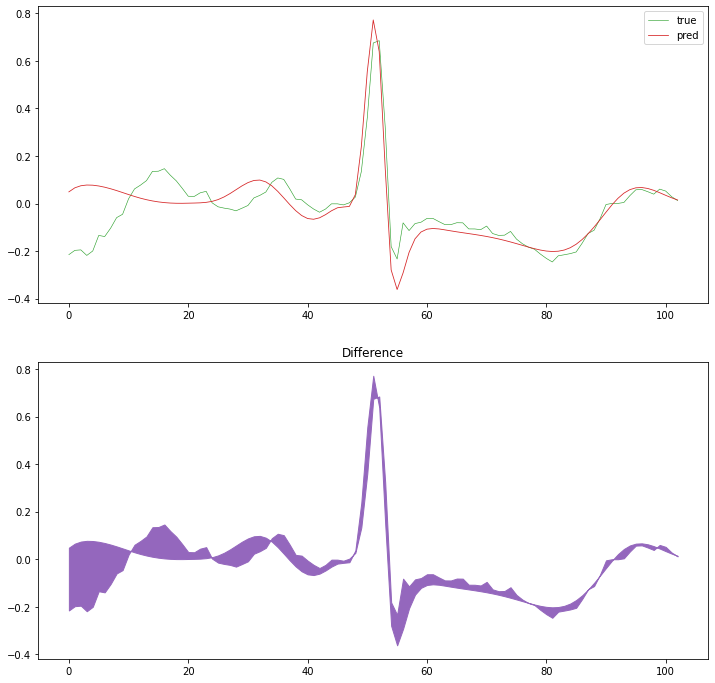

In [17]:
# predict other beats # randomly choose one normal and one abnormal

bii_normal = np.random.choice(NN_all)
bii_abnormal = np.random.choice(AA_all)
#print('Normal #',bii_normal, ' Label:', rec.mLabels[bii_normal],rec.iLabels[bii_normal])
for bii,tx in zip([bii_normal,bii_abnormal],['Normal#','Abnormal#']):
    print(tx, bii, ' Label:', rec.mLabels[bii],rec.iLabels[bii])
    signal_, _,_,_ = rec.get_signal_slice_biF(bii,lsamp, rsamp)
    assert (seqlen == len(signal_))
    sequence = signal_.reshape((1,seqlen, 1))
    ypred = model.predict(sequence, verbose=0)
    dE = np.abs(ypred[0,:,0] - sequence[0,:,0])
    print('Error:', Rec_Error(dE))
    
    fig,ax = plt.subplots(2,1,figsize=(12,12))
    ax[1].fill_between(np.arange(0,seqlen,1), ypred[0,:,0], sequence[0,:,0], color='tab:purple')
    ax[1].set_title('Difference')
    ax[0].plot(sequence[0,:,0], label='true', color='tab:green', linewidth=0.6)
    ax[0].plot(ypred[0,:,0], label='pred', color='tab:red', linewidth=0.8)
    ax[0].legend()
    plt.show()
    

# Testing

**Note: Choose equal number of beats from the normal and the abnormal class for testing**

...testing on samples: 4 [ 2 + 2 ]
Done!


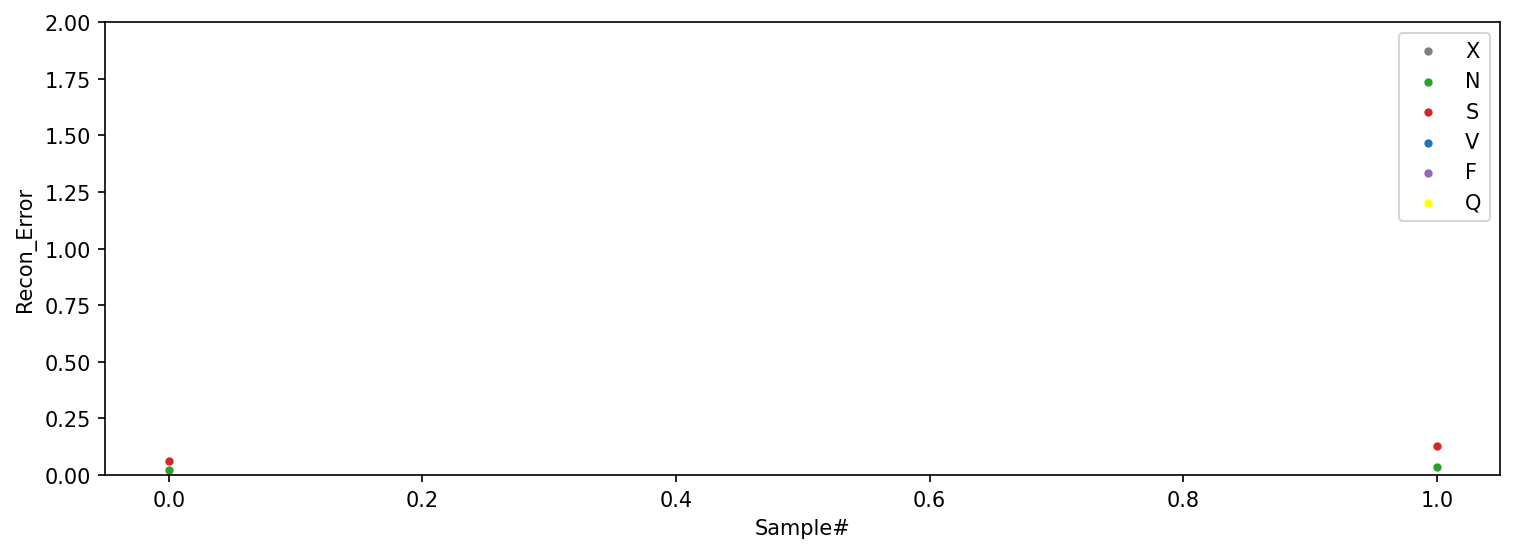

done!

Elapsed time =  0:00:00.365311


In [18]:
qN = NN_all #<----- choose from all Normal beats
qA = AA_all #<----- choose from all AbNormal beats

takes = min(len(qN),len(qA)) # take which ever is minimum

qN = np.random.choice(qN, size=takes, replace=False)
qA = np.random.choice(qA, size=takes, replace=False)

q = np.hstack((qA,qN))
print("...testing on samples:",len(q),'[', len(qN),'+', len(qA),']')

pred_dict = {_X:[]}
for cant in custom_ants:
    pred_dict[cant]= []
    # initialized dict
timestamp_start = datetime.datetime.now()
for bindex in q :
    signal_, _,_,_ = rec.get_signal_slice_biF(bindex,lsamp, rsamp)
    assert (seqlen == len(signal_))
    sequence = signal_.reshape((1,seqlen, 1))
    yhat = model.predict(sequence, verbose=0)
    dE = np.abs(yhat[0,:,0] - sequence[0,:,0])
    MAE = Rec_Error(dE)
    pred_dict[rec.mLabels[bindex]].append(MAE)
print('Done!')
# plot the predictions   
plt.figure(figsize=(12,4),dpi=150)
plt.ylim(0,e_ylim)
for _key in pred_dict.keys():
    #print(_key)
    plt.scatter(np.arange(0,len(pred_dict[_key]),1),pred_dict[_key], color=custom_cols[_key],marker='.',label=_key[1:])
#plt.hlines(20,0,100)
plt.ylabel('Recon_Error')
plt.xlabel('Sample#')
plt.legend()
plt.show()
#-------------------------------------
print('done!')
#print(pred_dict)
print('\nElapsed time = ',datetime.datetime.now() - timestamp_start)

# Automatic Thresholding for 2 classes - Normal v/s Abnormal

by looking probability distribution

Used Samples: (2,) + (2,) = (4,)


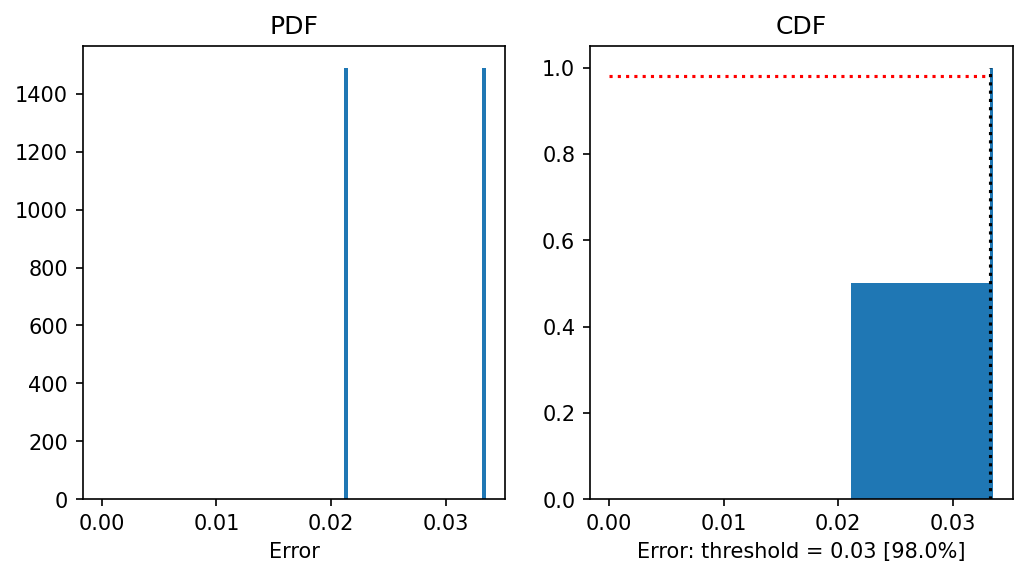

Threshold: 0.03320
Accuracy: 75.00000


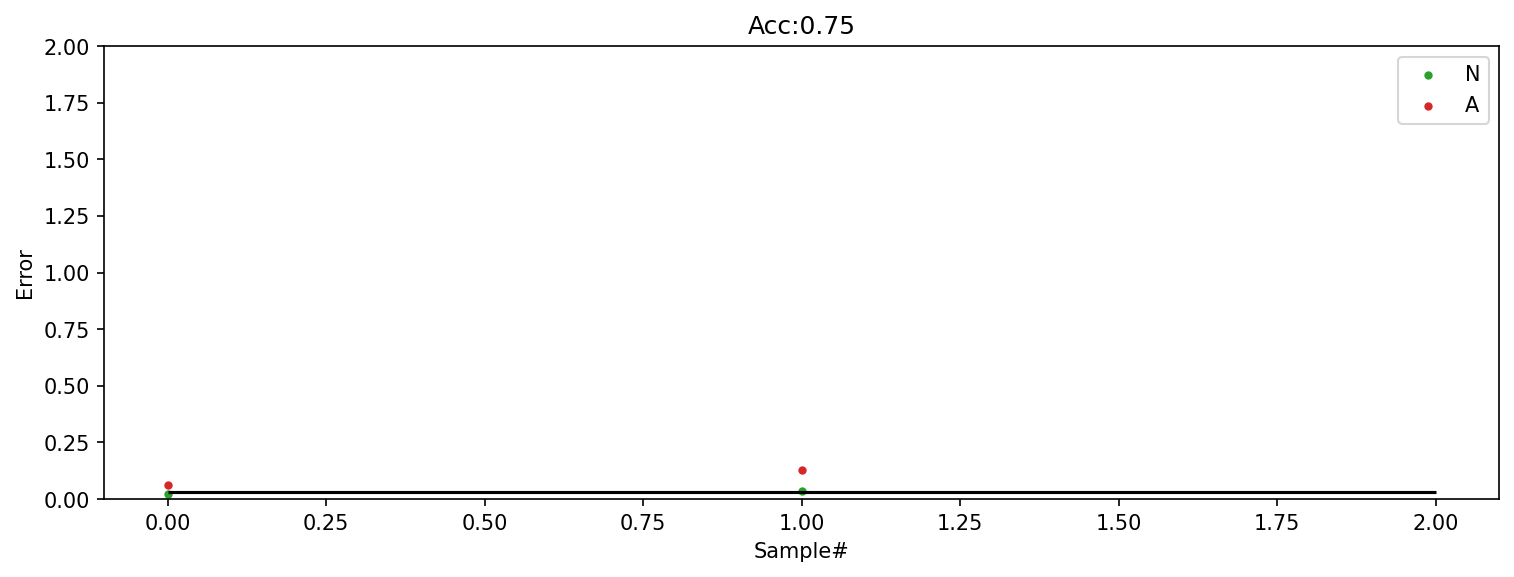

In [19]:

Npd = np.array(pred_dict[_N])
#Normalize Npd?

Apd = np.hstack((np.array(pred_dict[_S]),
                         np.array(pred_dict[_V]),
                         np.array(pred_dict[_F]),
                         np.array(pred_dict[_Q]),
                         np.array(pred_dict[_X])))
data_ = np.hstack((Npd, Apd))
print('Used Samples:', Npd.shape, '+',Apd.shape,'=', data_.shape)

pthresh = 0.98 #98% data - good enough?

fig,ax = plt.subplots(1,2,figsize=(8,4),dpi=150 )

n_pbin, n_bin, _ = ax[0].hist( Npd, bins=100,range=(0, np.max(Npd)),  density=True)
C_pbin, C_bin, _ = ax[1].hist( Npd, bins=100,range=(0, np.max(Npd)),  density=True, cumulative=True)

q_index = np.where(C_pbin>=pthresh)[0][0]
q_thresh = C_bin[q_index]
ax[1].vlines(q_thresh,0,1,color='black',linestyle='dotted')
#ax[0].vlines(q_thresh,0,1,color='black',linestyle='dotted')
ax[1].hlines(pthresh,0,q_thresh,color='red',linestyle='dotted')
#ax[0].hlines(pthresh,0,q_thresh,color='red',linestyle='dotted')

ax[0].set_title('PDF')
ax[0].set_xlabel('Error')
ax[1].set_title('CDF')
ax[1].set_xlabel('Error: threshold = '+str(round(q_thresh,2))+ ' ['+str(round(pthresh*100,2))+'%]')
plt.show()
#c_pbin, c_bin, _ = plt.hist( train_x, bins=100, range=(0, np.max(Nss)), cumulative=True)

TP_ = len(np.where(Npd<=q_thresh)[0]) # TP
FN_ = len(np.where(Npd>q_thresh)[0])  # FN

FP_ = len(np.where(Apd<=q_thresh)[0]) # FP
TN_ = len(np.where(Apd>q_thresh)[0])  # TN

acc_ = (TP_+TN_) / len(data_)
print('Threshold: %.5f' % (q_thresh))
print('Accuracy: %.5f' % (acc_*100))


plt.figure(figsize=(12,4),dpi=150)
plt.ylim(0,e_ylim)
plt.title('Acc:'+str(acc_))
plt.scatter(np.arange(0,len(Npd),1),Npd, color='tab:green',marker='.', label='N')
plt.scatter(np.arange(0,len(Apd),1),Apd, color='tab:red',marker='.', label='A')

plt.hlines(q_thresh,0,takes,color='black')
plt.legend()
_=plt.ylabel('Error')
_=plt.xlabel('Sample#')

#for i in range(0,len(pths)):


> a better method of automated thresholding of reconstruction error should be considered.

# Test on all beats of the Record

...testing on samples: 2537 [ 2535 + 2 ]


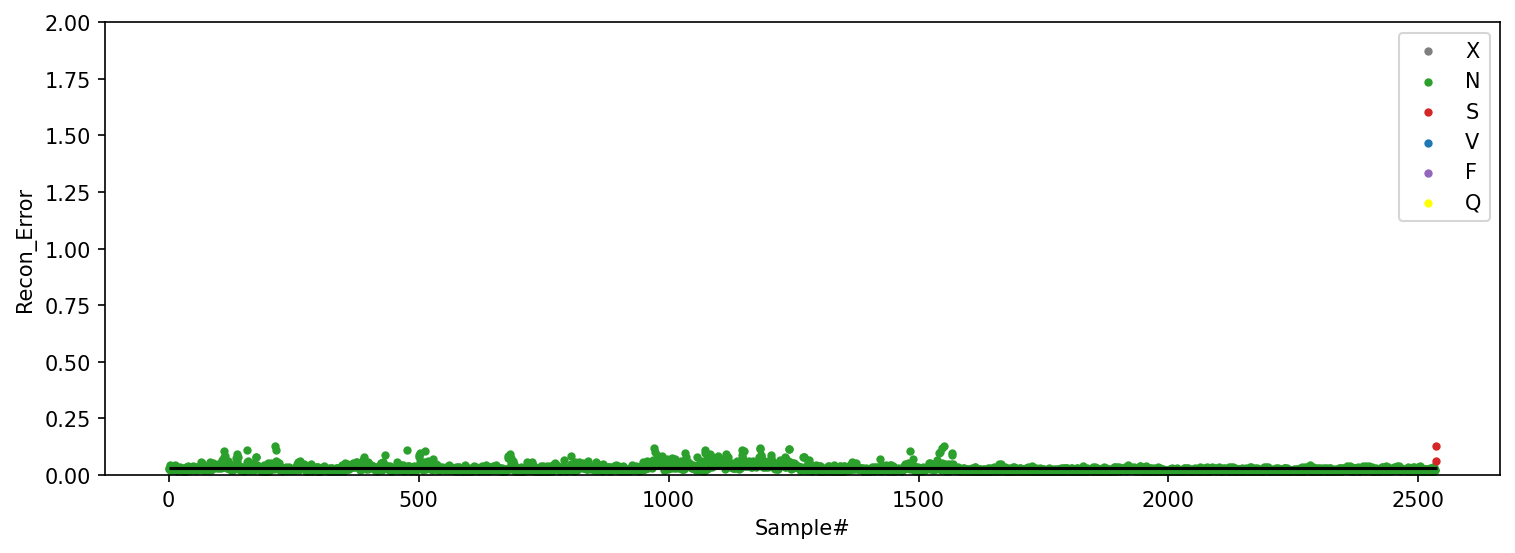

done!

Elapsed time =  0:01:38.454147


In [20]:
qN = NN_all #<----- choose from all Normal beats
qA = AA_all #<----- choose from all AbNormal beats

#takes = min(len(qN),len(qA)) # take which ever is minimum

#qN = np.random.choice(qN, size=takes, replace=False)
#qA = np.random.choice(qA, size=takes, replace=False)

q = np.hstack((qA,qN))
print("...testing on samples:",len(q),'[', len(qN),'+', len(qA),']')

pred_dict = {_X:[]}
for cant in custom_ants:
    pred_dict[cant]= []
    # initialized dict
timestamp_start = datetime.datetime.now()
for bindex in q :
    signal_, _,_,_ = rec.get_signal_slice_biF(bindex,lsamp, rsamp)
    assert (seqlen == len(signal_))
    sequence = signal_.reshape((1,seqlen, 1))
    yhat = model.predict(sequence, verbose=0)
    dE = np.abs(yhat[0,:,0] - sequence[0,:,0])
    MAE = Rec_Error(dE)
    pred_dict[rec.mLabels[bindex]].append(MAE)

# plot the predictions   
plt.figure(figsize=(12,4),dpi=150)
plt.ylim(0,e_ylim)
llen = 0
for _key in pred_dict.keys():
    slen = len(pred_dict[_key])
    plt.scatter(np.arange(0,slen,1)+llen,pred_dict[_key], color=custom_cols[_key],marker='.',label=_key[1:])
    llen+=slen
#plt.hlines(20,0,100)
plt.hlines(q_thresh,0,llen,color='black')
plt.ylabel('Recon_Error')
plt.xlabel('Sample#')
plt.legend()
plt.show()
#-------------------------------------
print('done!')
#print(pred_dict)
print('\nElapsed time = ',datetime.datetime.now() - timestamp_start)

# Evaluate using automatic threshold

Used Samples: (2535,) + (2,) = (2537,)
Threshold: 0.03320
Accuracy: 69.17619

	Confusion Matrix [N/A]
T\P	N	A
N	1753	782
A	0	2

Performance for 2 classes
Class	#True	#Pred	TPs	FNs	FPs	TNs	ACC	PRE	SEN	SPF	F1S
N	2535.0	1753.0	1753.0	782.0	0.0	2.0	0.69176	1.0	0.69152	1.0	0.81763
A	2.0	784.0	2.0	0.0	782.0	1753.0	0.69176	0.00255	1.0	0.69152	0.00509

Total Predictions	 2537
Correct Predictions	 1755 	 69.18 %
Incorrect Predictions	 782 	 30.82 %


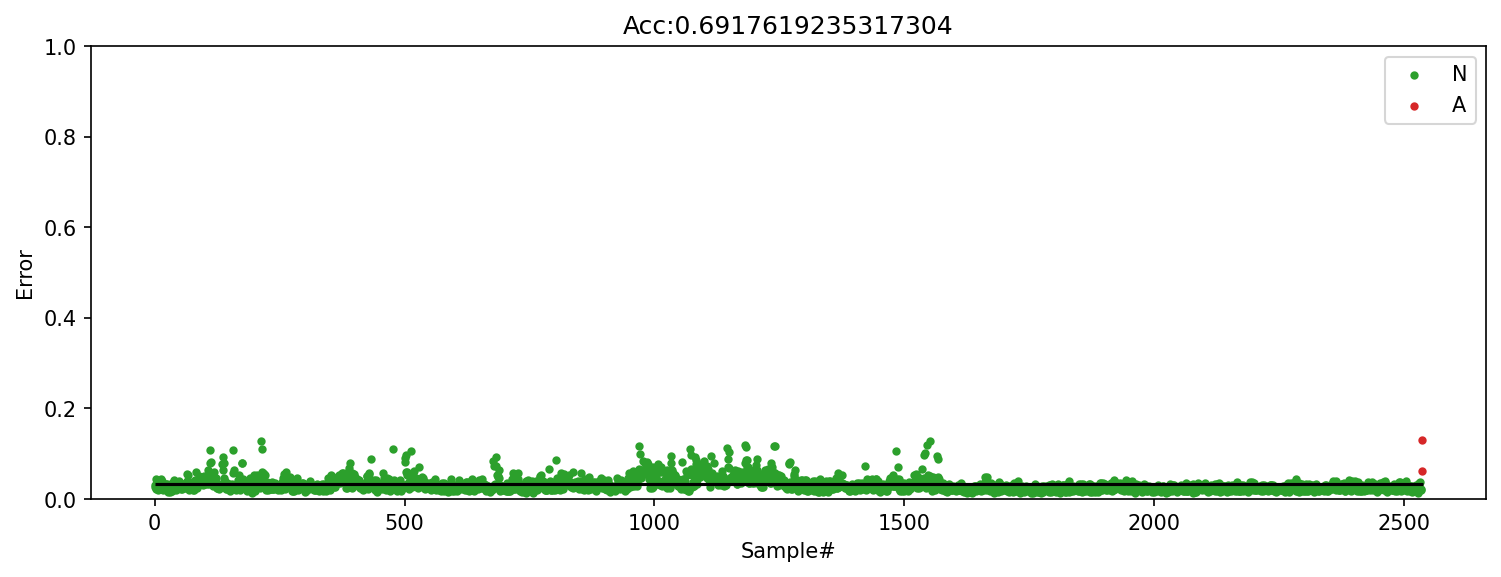

In [21]:
Npd = np.array(pred_dict[_N])
#Normalize Npd?

#(scaler.transform(data))

Apd = np.hstack((np.array(pred_dict[_S]),
                         np.array(pred_dict[_V]),
                         np.array(pred_dict[_F]),
                         np.array(pred_dict[_Q]),
                         np.array(pred_dict[_X])))
data_ = np.hstack((Npd, Apd))
print('Used Samples:', Npd.shape, '+',Apd.shape,'=', data_.shape)

TP_ = len(np.where(Npd<=q_thresh)[0]) # TP
FN_ = len(np.where(Npd>q_thresh)[0])  # FN

FP_ = len(np.where(Apd<=q_thresh)[0]) # FP
TN_ = len(np.where(Apd>q_thresh)[0])  # TN

acc_ = (TP_+TN_) / len(data_)
print('Threshold: %.5f' % (q_thresh))
print('Accuracy: %.5f' % (acc_*100))


plt.figure(figsize=(12,4),dpi=150)
plt.ylim(0,e_ylim/2)
plt.title('Acc:'+str(acc_))
plt.scatter(np.arange(0,len(Npd),1),Npd, color='tab:green',marker='.',label='N')
plt.scatter(np.arange(0,len(Apd),1)+len(Npd),Apd, color='tab:red',marker='.',label='A')

plt.hlines(q_thresh,0,len(data_),color='black')
plt.legend()
_=plt.ylabel('Error')
_=plt.xlabel('Sample#')


#@----------------------------------------->> conf matrix and performance measures
g_LABELS = ['N','A']
matrix = np.array([[TP_,FN_],[FP_,TN_]])
print('\n\tConfusion Matrix [N/A]')
print(print_conf_matrix( matrix, '', g_LABELS))
print_performance( matrix ,g_LABELS, do_round=5)

pC = TP_+TN_
pW = FP_+FN_
print('')
print('Total Predictions\t',(pC+pW))
print('Correct Predictions\t', pC,'\t', round((100*pC)/(pC+pW),2),'%')
print('Incorrect Predictions\t', pW,'\t', round((100*pW)/(pC+pW),2),'%')

# Test some more beats

Selected list count: 2
Predict on Samples: 2



# 1102  Label: _S A
Predicted: Abnormal  0.0965 :: above threshold
Error = 0.12970941337558467


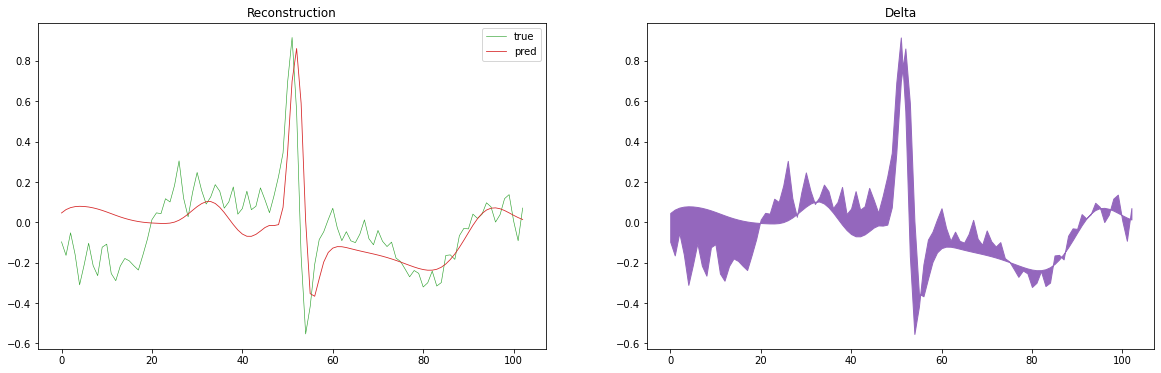


# 1003  Label: _S A
Predicted: Abnormal  0.0298 :: above threshold
Error = 0.06295834631958681


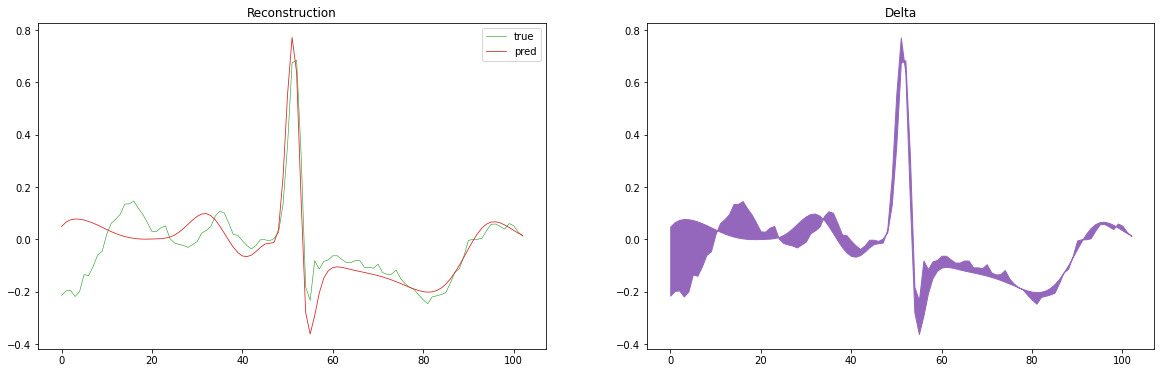

In [22]:
list_sel = AA_all  # NN_all, NN_true, NN_abs, AA_all, SS_all, VV_all, FF_all, QQ_all, XX_all
print('Selected list count:',len(list_sel))
assert (len(list_sel<1)) #<--- assert if zero beats in the list

bii_sel = np.random.choice(list_sel,size=min(10,len(list_sel)),replace=False)
#bii_sel = list_sel

print('Predict on Samples:', len(bii_sel))
print('\n')
for bii in bii_sel:
    print('\n#',bii, ' Label:', rec.mLabels[bii],rec.iLabels[bii])
    signal_, _,_,_ = rec.get_signal_slice_biF(bii,lsamp, rsamp)
    assert (seqlen == len(signal_))
    sequence = signal_.reshape((1,seqlen, 1))
    ypred = model.predict(sequence, verbose=0)
    dE = np.abs(ypred[0,:,0] - sequence[0,:,0])
    RErr = Rec_Error(dE)
    #print('Error , Threshold:',RErr,',',q_thresh)
    
    if RErr>q_thresh:
        print('Predicted: Abnormal ',round(RErr-q_thresh,4),':: above threshold')
    else:
        print('Predicted: Normal ',round(RErr-q_thresh,4),':: below threshold')
    print('Error =',RErr)
    #print()
    fig,ax = plt.subplots(1,2,figsize=(20,6))
    ax[1].fill_between(np.arange(0,seqlen,1), ypred[0,:,0], sequence[0,:,0], color='tab:purple')
    ax[1].set_title('Delta')
    ax[0].set_title('Reconstruction')
    ax[0].plot(sequence[0,:,0], label='true', color='tab:green', linewidth=0.6)
    ax[0].plot(ypred[0,:,0], label='pred', color='tab:red', linewidth=0.8)
    ax[0].legend()
    plt.show()
    

**Concluding Remarks**

> With the choosen beat repsentation, this simple LSTM can seperate out the N and V classes very well but cannot differentiate between N and F types beats based on reconstruction error.


**The End**